# S&P 500 Analysis

## Import the Packages, Functions and Data

In [1]:
import pandas as pd
from EDA_functions import *
from Baseline_functions import *
from DQN_functions import *
import pandas as pd
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle('data/SP500.pkl')

## Outlier Removal 


In [3]:
df['daily_return'] = df['Close'].pct_change()
df['daily_return'] = df['daily_return'].fillna(0)
#mean plus 3sigma value for absolute daily returns
mean = df['daily_return'].mean()
std = df['daily_return'].std()
upper_limit = mean + 2*std
lower_limit = mean - 2*std
print(f'Mean: {mean}, Std: {std}, Upper Limit: {upper_limit}, Lower Limit: {lower_limit}')
#number of rows that are outside the 3 sigma range
print(f'Number of rows outside 2 sigma range: {len(df[(df["daily_return"]>upper_limit) | (df["daily_return"]<lower_limit)])}')
print(f'Percentage of rows outside 2 sigma range: {len(df[(df["daily_return"]>upper_limit) | (df["daily_return"]<lower_limit)])/len(df)*100}% ')

#if daily return is outside 3 sigma range, replace all the values with previous day's values
for i in range(1,len(df)):
    if df['daily_return'][i]>upper_limit or df['daily_return'][i]<lower_limit:
        df['Close'][i] = df['Close'][i-1]
        df['Open'][i] = df['Open'][i-1]
        df['High'][i] = df['High'][i-1]
        df['Low'][i] = df['Low'][i-1]
        df['Volume'][i] = df['Volume'][i-1]
        df['daily_return'][i] = 'NaN'

Mean: 0.00037873998112499885, Std: 0.012040180200659603, Upper Limit: 0.024459100382444206, Lower Limit: -0.023701620420194205
Number of rows outside 2 sigma range: 244
Percentage of rows outside 2 sigma range: 4.848003179018478% 


## DQN

### Training

### Without Moving Averages

In [5]:
df_base = df[['Open','High','Low','Close','Volume']]
#include 26 and 12 ema
# df_base['26ema'] = df_base['Close'].ewm(span=26).mean()
# df_base['12ema'] = df_base['Close'].ewm(span=12).mean()
#fill na as 0
# df_base = df_base.dropna()
# df_base = df_base[['Open','High','Low','Close','Volume','26ema','12ema']]

#first 80% of the data is train
df_train = df_base.iloc[:int(len(df_base)*0.8)]
#last 20% of the data is test
df_test = df_base.iloc[int(len(df_base)*0.8):]

In [6]:
display(df_train.head())

display(df_test.head())

,Open,High,Low,Close,Volume
Date,,,,,
2004-03-31,1127.000000,1130.829956,1121.459961,1126.209961,1560700000
2004-04-01,1126.209961,1135.670044,1126.199951,1132.170044,1560700000
2004-04-02,1132.170044,1144.810059,1132.170044,1141.810059,1629200000
2004-04-05,1141.810059,1150.569946,1141.640015,1150.569946,1413700000
2004-04-06,1150.569946,1150.569946,1143.300049,1148.160034,1397700000


,Open,High,Low,Close,Volume
Date,,,,,
2020-03-30,2457.770020,2571.419922,2407.530029,2475.560059,8300010000
2020-03-31,2614.689941,2641.389893,2571.149902,2584.590088,6576210000
2020-04-01,2614.689941,2641.389893,2571.149902,2584.590088,6576210000
2020-04-02,2458.540039,2533.219971,2455.790039,2526.899902,6464190000
2020-04-03,2514.919922,2538.179932,2459.959961,2488.649902,6096970000


In [7]:
print(df_train.shape, df_test.shape)
print(df_train.shape[0] + df_test.shape[0])
print(df.shape[0])

(4026, 5) (1007, 5)
5033
5033


In [8]:
window_size = 26
states = create_states(df_train, window_size)
test_states = create_states(df_test, window_size)
input_dim_conv = states.shape[2]
output_dim = 3
print("Shape of states:", states.shape)

Shape of states: (4000, 26, 5)


In [9]:
model = ConvDQN(input_dim_conv, output_dim, window_size)
memory = ReplayMemory(50000)
agent = DQNAgent(input_dim_conv, output_dim, window_size,model, lr=0.0001, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9995)

Episode 1/800, Total Reward: 8.681158798022464, Loss: 26.58540313799663
Episode 2/800, Total Reward: 0.0, Loss: 26.34372884566018
Episode 3/800, Total Reward: 9.645731997802738, Loss: 25.919003449399593
Episode 4/800, Total Reward: -5.325354728801684, Loss: 21.507165452005836
Episode 5/800, Total Reward: 0.0, Loss: 19.27735007461597
Episode 6/800, Total Reward: 0.0, Loss: 20.408569733095423
Episode 7/800, Total Reward: -369.37132536621095, Loss: 18.06908954158813
Episode 8/800, Total Reward: -295.95770507812506, Loss: 15.946205893251514
Episode 9/800, Total Reward: 7.8130429182202175, Loss: 14.051103493113736
Episode 10/800, Total Reward: -1.1788188565498603, Loss: 9.740630330529777
Episode 11/800, Total Reward: -6.396100856548372e-08, Loss: 5.506782115205017
Episode 12/800, Total Reward: 0.0017551736070505312, Loss: 6.2645855922209694
Episode 13/800, Total Reward: 7.847408830737306, Loss: 6.314600680221659
Episode 14/800, Total Reward: -4.0921587223443136e-09, Loss: 6.123525791066119


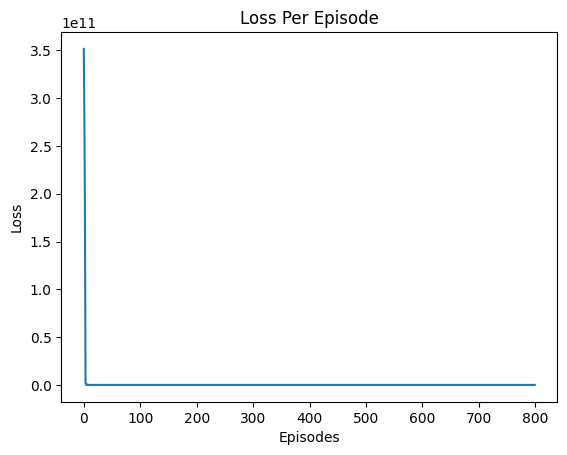

CPU times: user 1d 4h 13min 14s, sys: 6h 57min 3s, total: 1d 11h 10min 18s
Wall time: 8h 28min 56s


In [10]:
%%time
log_train = train_agent(agent, states, 800, batch_size=32)

In [11]:
log_train

,Episode,Time,Reward,Action,Price,Loss
0,1,1,0.000000e+00,Hold,1113.989990,3.514745e+11
1,1,2,0.000000e+00,Buy,1098.699951,3.514745e+11
2,1,3,0.000000e+00,Hold,1087.119995,3.514745e+11
3,1,4,0.000000e+00,Hold,1095.449951,3.514745e+11
4,1,5,0.000000e+00,Hold,1097.280029,3.514745e+11
...,...,...,...,...,...,...
3199195,800,3995,2.565708e-19,Hold,2409.389893,6.054852e-01
3199196,800,3996,2.309137e-19,Hold,2409.389893,6.054852e-01
3199197,800,3997,2.078223e-19,Hold,2409.389893,6.054852e-01
3199198,800,3998,1.870401e-19,Hold,2409.389893,6.054852e-01


In [12]:
log_train.to_csv('SP500/log_train_CNN_updated_reward_800ep.csv', index=False)

In [13]:
#save the model
torch.save(agent.model.state_dict(), 'SP500/DQN_CNN_updated_reward_800ep.pth')


In [15]:
%%capture

log_train.rename(columns={'Reward':'Training_reward'}, inplace=True)

reward =[]
for i in range(1,log_train['Episode'].max()+1):
    last_episode = log_train[log_train['Episode'] == i]
    last_episode.reset_index(drop=True, inplace=True)
    last_episode['Close'] = last_episode['Price'].to_list()
    reward.append(list(capital_calculation(last_episode,'Action'))[-1]-100)

log_train['Reward'] = log_train['Episode'].apply(lambda x: reward[x-1])

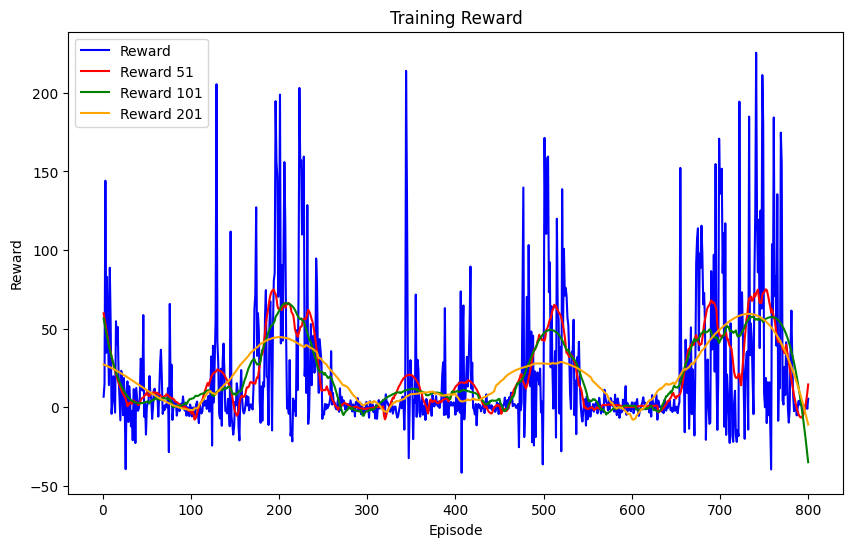

In [16]:
reward_filter(reward)

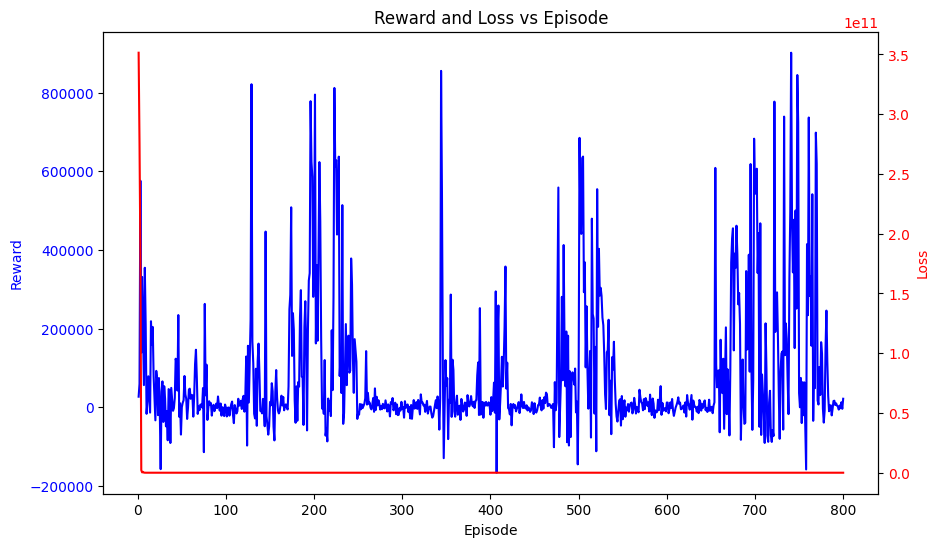

In [17]:
plot_training(log_train)

In [18]:
action_episode_df = create_action_episode_df(log_train)
action_episode_df = action_episode_df.apply(pd.Series.value_counts).transpose().reset_index()

<Axes: >

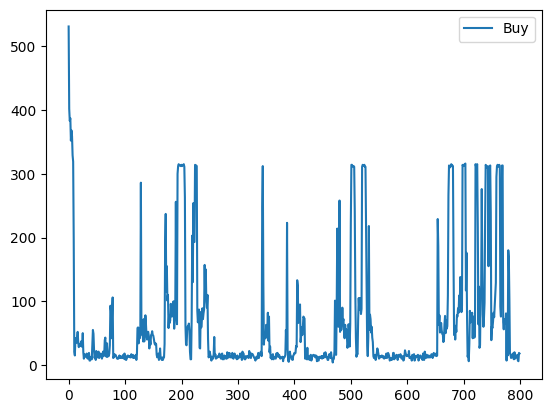

In [19]:
action_episode_df[['Buy']].plot()

In [20]:
# Initialize the agent
test_state_size = test_states.shape[2]
action_size = 3
model = ConvDQN(input_dim_conv, output_dim, window_size)
agent = DQNAgent(test_state_size, output_dim, window_size,model, lr=0.0001, gamma=0.95, epsilon=0, epsilon_min=0, epsilon_decay=0.9995)

# Ensure the model is in evaluation mode
agent.model.eval()

ConvDQN(
  (conv1): Conv1d(5, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=1664, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [21]:
evaluation_log = evaluate_agent(agent, test_states)
evaluation_log['Close'] = evaluation_log['Price']
evaluation_log['Capital'] = capital_calculation(evaluation_log, 'Action')

Total Pofit: 7.559325609089129


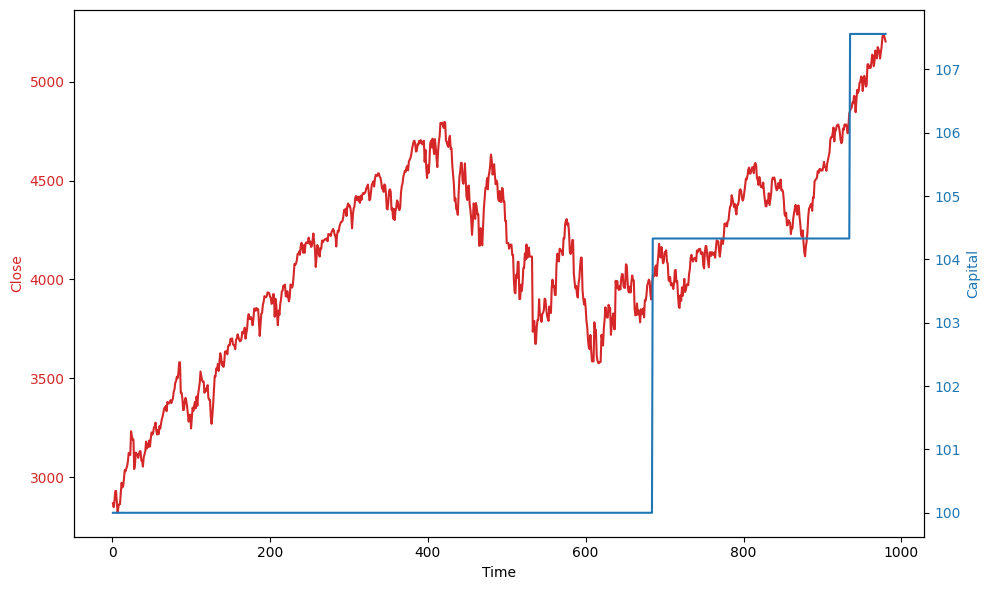

In [22]:
plot_dual_axis(evaluation_log)

### With MA, without short term basis

In [5]:
df_base = df[['Open','High','Low','Close','Volume']]
# include 26 and 12 ema
df_base['26ema'] = df_base['Close'].ewm(span=26).mean()
df_base['12ema'] = df_base['Close'].ewm(span=12).mean()
# fill na as 0
df_base = df_base.dropna()
df_base = df_base[['Open','High','Low','Close','Volume','26ema','12ema']]

#first 80% of the data is train
df_train = df_base.iloc[:int(len(df_base)*0.8)]
#last 20% of the data is test
df_test = df_base.iloc[int(len(df_base)*0.8):]

In [6]:
display(df_train.head())

display(df_test.head())

,Open,High,Low,Close,Volume,26ema,12ema
Date,,,,,,,
2004-03-31,1127.000000,1130.829956,1121.459961,1126.209961,1560700000,1126.209961,1126.209961
2004-04-01,1126.209961,1135.670044,1126.199951,1132.170044,1560700000,1129.304619,1129.438339
2004-04-02,1132.170044,1144.810059,1132.170044,1141.810059,1629200000,1133.797702,1134.267024
2004-04-05,1141.810059,1150.569946,1141.640015,1150.569946,1413700000,1138.486489,1139.413220
2004-04-06,1150.569946,1150.569946,1143.300049,1148.160034,1397700000,1140.729824,1141.789698


,Open,High,Low,Close,Volume,26ema,12ema
Date,,,,,,,
2020-03-30,2457.770020,2571.419922,2407.530029,2475.560059,8300010000,2788.802479,2596.828742
2020-03-31,2614.689941,2641.389893,2571.149902,2584.590088,6576210000,2773.675635,2594.945872
2020-04-01,2614.689941,2641.389893,2571.149902,2584.590088,6576210000,2759.669298,2593.352674
2020-04-02,2458.540039,2533.219971,2455.790039,2526.899902,6464190000,2742.427121,2583.129171
2020-04-03,2514.919922,2538.179932,2459.959961,2488.649902,6096970000,2723.628808,2568.593899


In [7]:
print(df_train.shape, df_test.shape)
print(df_train.shape[0] + df_test.shape[0])
print(df.shape[0])

(4026, 7) (1007, 7)
5033
5033


In [8]:
window_size = 26
states = create_states(df_train, window_size)
test_states = create_states(df_test, window_size)
input_dim_conv = states.shape[2]
output_dim = 3
print("Shape of states:", states.shape)

Shape of states: (4000, 26, 7)


In [9]:
model = ConvDQN(input_dim_conv, output_dim, window_size)
memory = ReplayMemory(50000)
agent = DQNAgent(input_dim_conv, output_dim, window_size,model, lr=0.0001, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9995)

Episode 1/800, Total Reward: 0.0, Loss: 23.739349481326954
Episode 2/800, Total Reward: 66.170166015625, Loss: 23.549392838907337
Episode 3/800, Total Reward: 0.0, Loss: 21.714029135530186
Episode 4/800, Total Reward: -496.81005859375, Loss: 18.150159590333292
Episode 5/800, Total Reward: 0.0, Loss: 15.586919604883855
Episode 6/800, Total Reward: 0.0, Loss: 13.844852528447085
Episode 7/800, Total Reward: -165.0971016626441, Loss: 11.232090315419118
Episode 8/800, Total Reward: 5.70241219743138e-31, Loss: 6.414592267885112
Episode 9/800, Total Reward: 33.16908148700384, Loss: 6.57353830983236
Episode 10/800, Total Reward: -5.084640479299948e-12, Loss: 5.846197427745776
Episode 11/800, Total Reward: 32.53902184910815, Loss: 6.598831448478971
Episode 12/800, Total Reward: 3.726566164126342e-10, Loss: 5.450093665169284
Episode 13/800, Total Reward: 1.7556663278894153e-05, Loss: 7.248218998429418
Episode 14/800, Total Reward: 55.339082114308624, Loss: 8.051869531510448
Episode 15/800, Total

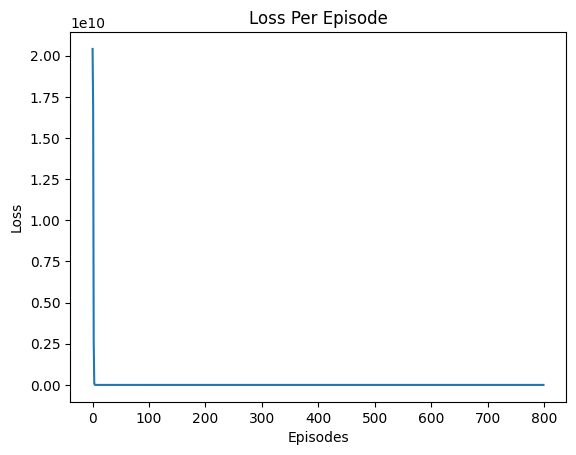

CPU times: user 1d 5h 20min 6s, sys: 7h 41min 44s, total: 1d 13h 1min 50s
Wall time: 9h 46min 9s


In [11]:
%%time
log_train = train_agent_long(agent, states, 800, batch_size=32)

In [12]:
log_train.to_csv('SP500/log_train_CNN__reward_800ep_long.csv', index=False)

In [13]:
#save the model
torch.save(agent.model.state_dict(), 'SP500/DQN_CNN_updated_reward_800ep_long.pth')


In [14]:
%%capture

log_train.rename(columns={'Reward':'Training_reward'}, inplace=True)

reward =[]
for i in range(1,log_train['Episode'].max()+1):
    last_episode = log_train[log_train['Episode'] == i]
    last_episode.reset_index(drop=True, inplace=True)
    last_episode['Close'] = last_episode['Price'].to_list()
    reward.append(list(capital_calculation(last_episode,'Action'))[-1]-100)

log_train['Reward'] = log_train['Episode'].apply(lambda x: reward[x-1])

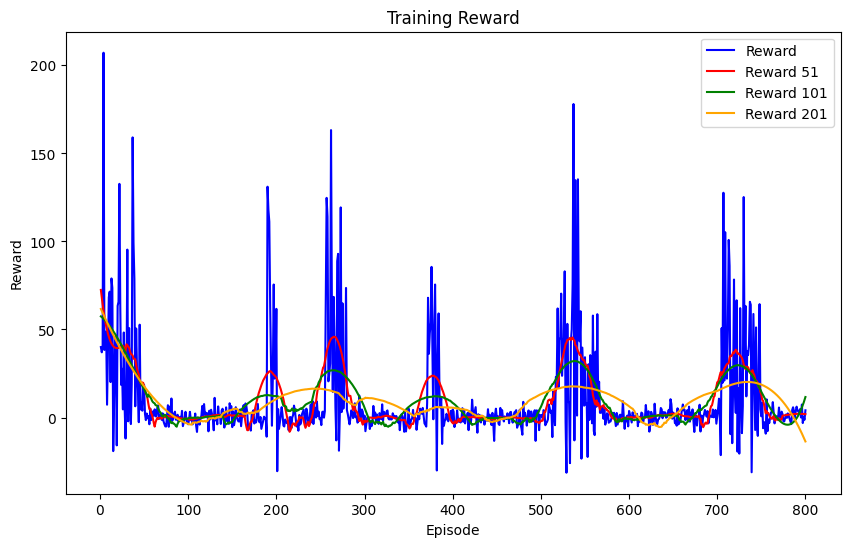

In [15]:
reward_filter(reward)

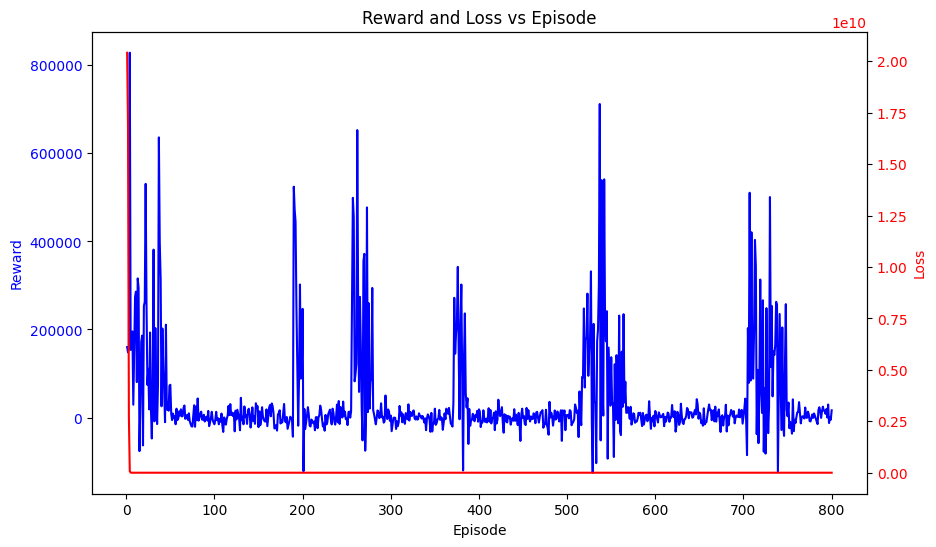

In [16]:
plot_training(log_train)

In [17]:
action_episode_df = create_action_episode_df(log_train)
action_episode_df = action_episode_df.apply(pd.Series.value_counts).transpose().reset_index()

In [22]:
action_episode_df

,index,Hold,Buy,Sell
0,action_ep1,3240,380,379
1,action_ep2,3207,396,396
2,action_ep3,3252,374,373
3,action_ep4,3253,373,373
4,action_ep5,3240,380,379
...,...,...,...,...
795,action_ep796,3969,15,15
796,action_ep797,3971,14,14
797,action_ep798,3981,9,9
798,action_ep799,3973,13,13


<Axes: >

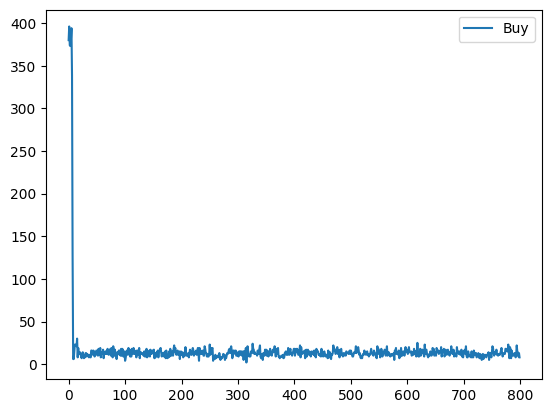

In [18]:
action_episode_df[['Buy']].plot()

In [19]:
# Initialize the agent
test_state_size = test_states.shape[2]
action_size = 3
model = ConvDQN(input_dim_conv, output_dim, window_size)
agent = DQNAgent(test_state_size, output_dim, window_size,model, lr=0.0001, gamma=0.95, epsilon=0, epsilon_min=0, epsilon_decay=0.9995)

# Ensure the model is in evaluation mode
agent.model.eval()

ConvDQN(
  (conv1): Conv1d(7, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=1664, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [20]:
evaluation_log = evaluate_agent(agent, test_states)
evaluation_log['Close'] = evaluation_log['Price']
evaluation_log['Capital'] = capital_calculation(evaluation_log, 'Action')

Total Pofit: 8.569227624482664


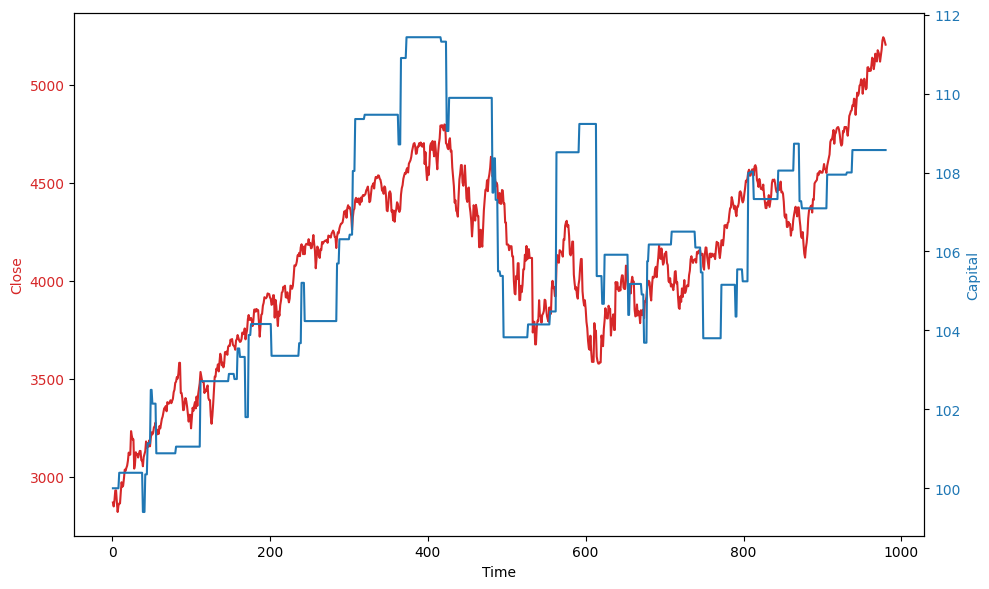

In [21]:
plot_dual_axis(evaluation_log)